## Step 1: Load Preprocessed Data & Artifacts

In this step, we load the preprocessed training data along with the transformation artifacts.  
- **X_train_df** and **y_train_df** contain the features and target variables, respectively.  
- The **StandardScaler**, **cat_vocab**, and **cat_mapping** ensure that numeric features are standardized and categorical features are encoded consistently.

This preparation sets the stage for the diffusion model by guaranteeing that our input data adheres to the same pre-processing applied during data preparation.


## Step 1b: Compute Observed Range for Engineered Features

The engineered features (extracted from datetime information: 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek') are expected to follow a given range in real fraud data.  
- We compute the column-wise minimum and maximum values (in the standardized space) using only the fraud samples.
- These observed ranges are later used in the **engineered range loss** and during synthesis to clip generated values so that they remain realistic.

## Step 2: Create Custom Dataset for Fraud Samples

We define the `SparkovFraudDataset` class to package both the numeric and the categorical fraud data into a format that can be easily consumed by a PyTorch DataLoader.  


## Step 3: Set Device and Diffusion Hyperparameters

Here we decide which compute device to use (GPU if available) and define key parameters for the diffusion process:
- **T_train:** Total number of diffusion timesteps.
- **beta, alpha, alpha_hat:** These define the noise schedule used to progressively corrupt the original data.
- **Loss weights (w1, w2, lambda_eng):** Hyperparameters for balancing the loss components during training.

## Step 4: Define the Diffusion Model

The `CombinedNoisePredictor` network is implemented here. It processes:
- **Numeric Features:** Directly used after standard scaling.
- **Categorical Features:** Passed through embedding layers.
- **Time Embedding:** A normalized timestep is concatenated with the features.

Together, these form a combined input that is processed through a multi-layer perceptron (MLP) with LeakyReLU activations to predict the noise added during the forward diffusion.

## Step 5: Define Loss Functions and Forward Diffusion Process

This section defines:
- **Forward Diffusion Function:** Adds noise to the clean data based on the noise schedule.
- **Loss Functions:**
  - **L_norm (MSE Loss):** Measures the difference between the predicted noise and the true noise.
  - **L_prior (Probability-Based Loss):** Encourages the predicted noise to match the distribution of non-fraud data.
  - **L_triplet (Contrastive/Triplet Loss):** Separates the estimated denoised fraud sample from non-fraud samples.
  - **L_eng (Engineered Range Loss):** Penalizes generated engineered features that fall outside the observed range.
  
The overall loss is a weighted sum of these components.

## Step 6: Train the Diffusion Model

We now iterate over the fraud dataset to train our diffusion model. For each batch:
- A random timestep is sampled for each data point.
- The forward diffusion function corrupts the clean fraud data.
- The model predicts the noise.
- All defined loss components (MSE, probability, triplet, engineered range) are computed and summed.
- The gradients are then backpropagated to update the model parameters.

Loss values are printed every 10 epochs to monitor training progress.

## Step 7: Generate Synthetic Fraud Samples

After the model is trained, we generate synthetic fraud samples using a reverse diffusion process:
- Starting from the mean and standard deviation of fraud data and a random noise input, the model iteratively removes noise.
- During synthesis, engineered features are clipped to the observed range to ensure realistic values.

## Step 8: Inverse Transform Numeric Features

The synthetic numeric samples generated by the diffusion process are in a normalized scale. Here we apply the inverse transform (using our StandardScaler) so that the synthetic data returns to its original scale.  
This transformation is crucial for proper interpretation and further evaluation.

## Step 9: Combine Numeric and Categorical Data and Evaluate

Finally, we:
- Concatenate the inverse-transformed numeric data with the synthetic categorical data.
- Form the complete synthetic fraud dataset.
- Evaluate the quality of the synthetic samples by comparing key descriptive statistics (using DataFrame summaries) and visualizing the distributions with histograms.

This final step lets us assess how similar the synthetic data is to the real fraud data.

Loaded StandardScaler and categorical artifacts.
Engineered features - observed min: [-1.87890062 -1.67309039 -1.79624861 -1.3500817 ] max: [1.49563575 1.70671805 1.41547433 1.37969415]
Using device: cpu
Categorical vocabulary sizes: {'merchant': 693, 'category': 14, 'gender': 2, 'street': 999, 'city': 906, 'state': 51, 'zip': 985, 'job': 497}
Starting training …
Epoch [1/250], Loss: 0.6018
Epoch [10/250], Loss: 0.2577
Epoch [20/250], Loss: 0.1791
Epoch [30/250], Loss: 0.1569
Epoch [40/250], Loss: 0.1353
Epoch [50/250], Loss: 0.1275
Epoch [60/250], Loss: 0.1149
Epoch [70/250], Loss: 0.1151
Epoch [80/250], Loss: 0.1056
Epoch [90/250], Loss: 0.1043
Epoch [100/250], Loss: 0.0969
Epoch [110/250], Loss: 0.0969
Epoch [120/250], Loss: 0.0892
Epoch [130/250], Loss: 0.0924
Epoch [140/250], Loss: 0.0923
Epoch [150/250], Loss: 0.0898
Epoch [160/250], Loss: 0.0856
Epoch [170/250], Loss: 0.0908
Epoch [180/250], Loss: 0.0815
Epoch [190/250], Loss: 0.0783
Epoch [200/250], Loss: 0.0762
Epoch [210/250]

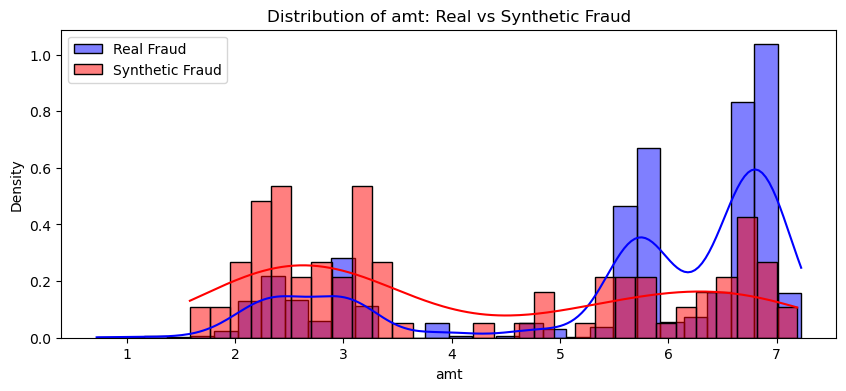

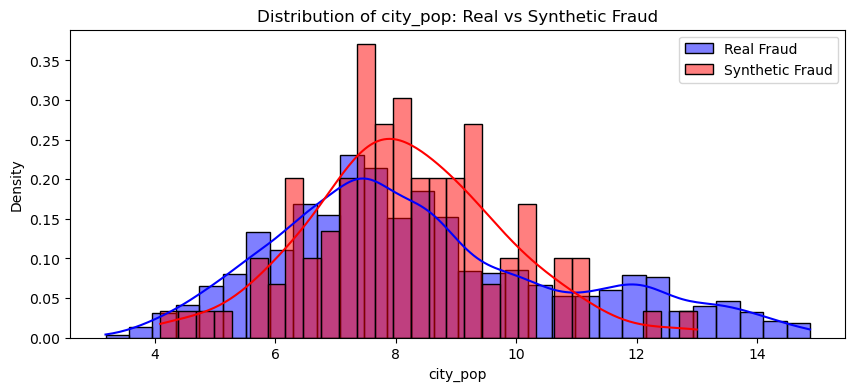

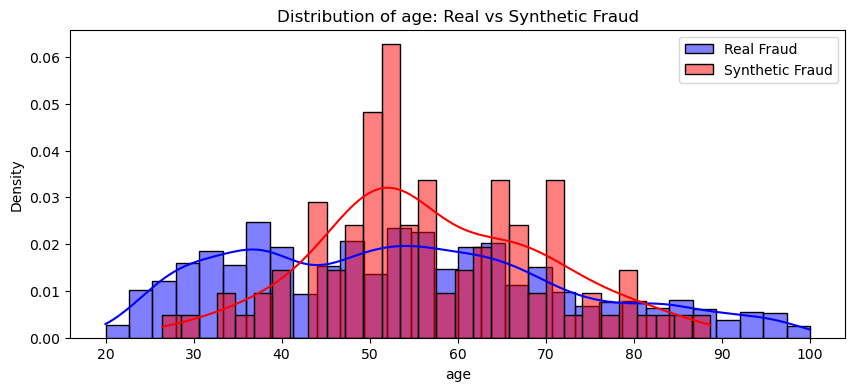

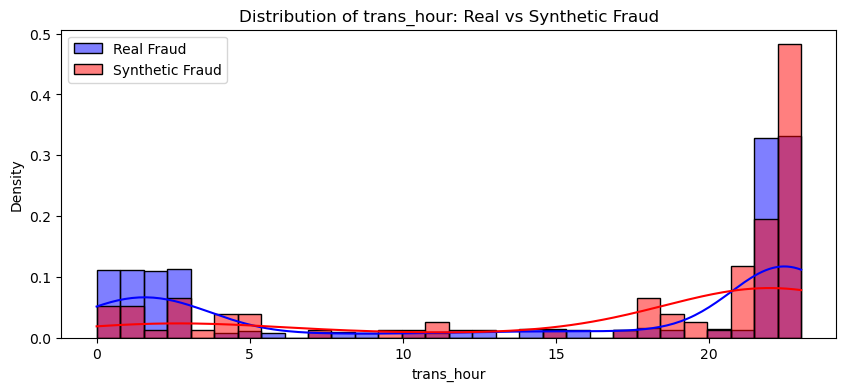

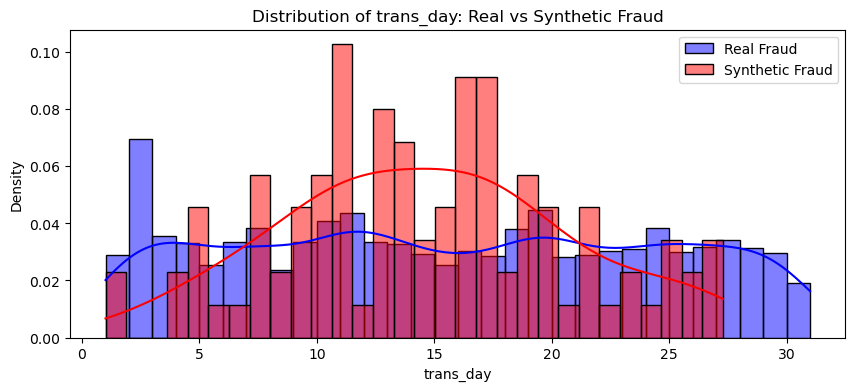

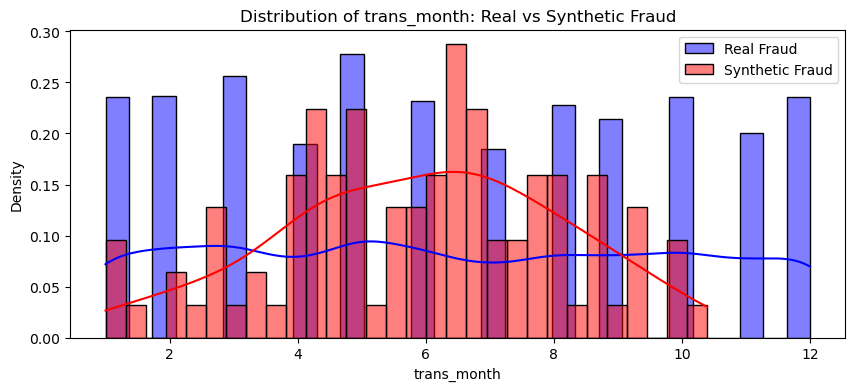

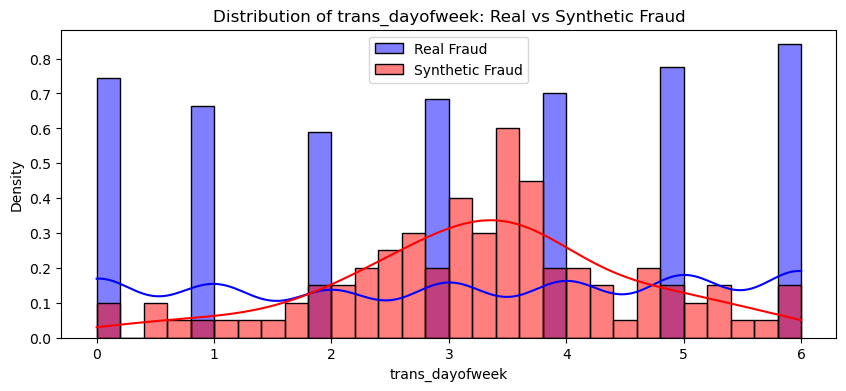

In [ ]:
"""
Improved FraudDiffuse Model – End-to-End using ONLY StandardScaler
Based strictly on Data_Preprocessing.ipynb (which applied StandardScaler to all numeric features).
Improvements:
  • We compute the observed min/max values (in the standardized space) for engineered features.
  • During training we add an extra loss to penalize denoised values for engineered features falling outside the observed range.
  • During synthesis we also clip the engineered features to that range.
"""

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random






# seeds


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)


#############################################
# Step 1: Load Preprocessed Data & Artifacts
#############################################
# Use raw strings to avoid escape-sequence issues.
X_train_df = pd.read_csv(r"Data\processed\X_train.csv")
y_train_df = pd.read_csv(r"Data\processed\y_train.csv")

scaler = joblib.load(r"Data\processed\standard_scaler.pkl")
cat_vocab = joblib.load(r"Data\processed\cat_vocab.pkl")
cat_mapping = joblib.load(r"Data\processed\cat_mapping.pkl")
print("Loaded StandardScaler and categorical artifacts.")

# Define feature lists exactly as used during preprocessing.
# All numeric features were standard-scaled.
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
                    'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
# Categorical features (factorized)
cat_features = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']

# Get target values (assume first column in y_train_df is target).
y_train = y_train_df.iloc[:, 0]

# Create masks.
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

# Filter training data.
X_train_num = X_train_df[numeric_features].loc[fraud_mask].values   # Standard-scaled numeric features.
X_train_cat = X_train_df[cat_features].loc[fraud_mask].values         # Integer codes.

X_nonfraud_num = X_train_df[numeric_features].loc[nonfraud_mask].values

#############################################
# Step 1b: Compute observed range for engineered features
#############################################
# Engineered features are those extracted from datetime:
eng_features = ['trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
# Find their indices in "numeric_features"
eng_indices = [numeric_features.index(feat) for feat in eng_features]

# Compute column-wise min and max for engineered features from the fraud training set
# (They are in standardized space.)
eng_min_np = np.min(X_train_num[:, eng_indices], axis=0)
eng_max_np = np.max(X_train_num[:, eng_indices], axis=0)
# Convert to torch tensors
eng_min = torch.tensor(eng_min_np, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
eng_max = torch.tensor(eng_max_np, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
print("Engineered features - observed min:", eng_min_np, "max:", eng_max_np)

#############################################
# Step 2: Create a Custom Dataset for Fraud Samples
#############################################
class SparkovFraudDataset(Dataset):
    def __init__(self, num_data, cat_data):
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
    def __len__(self):
        return self.num_data.shape[0]
    def __getitem__(self, idx):
        return self.num_data[idx], self.cat_data[idx]

fraud_dataset = SparkovFraudDataset(X_train_num, X_train_cat)

#############################################
# Step 3: Set Device and Diffusion Hyperparameters
#############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

T_train = 800
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T_train).to(device)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0)

w1 = 0
w2 = 0.1
lambda_eng = 0.05   # weight for engineered range loss

#############################################
# Step 4: Define the Diffusion Model
#############################################
class CombinedNoisePredictor(nn.Module):
    """
    This model follows the paper:
      - It takes in standard-scaled numeric features and factorized categorical features.
      - Categorical features are embedded and concatenated with numeric features.
      - A normalized timestep is appended.
      - The resulting vector is passed through an MLP (with LeakyReLU) to predict added noise.
    """
    def __init__(self, num_input_dim, cat_vocab_sizes, cat_embed_dim=20, hidden_dim=256):
        super(CombinedNoisePredictor, self).__init__()
        self.embeddings = nn.ModuleDict()
        for col, vocab in cat_vocab_sizes.items():
            self.embeddings[col] = nn.Embedding(vocab, cat_embed_dim)
        cat_total_dim = len(cat_vocab_sizes) * cat_embed_dim
        combined_input_dim = num_input_dim + cat_total_dim
        self.fc1 = nn.Linear(combined_input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, combined_input_dim)
        self.activation = nn.LeakyReLU()
    def forward(self, x_num, x_cat, t):
        embeds = []
        for i, col in enumerate(self.embeddings):
            emb = self.embeddings[col](x_cat[:, i])
            embeds.append(emb)
        x_cat_emb = torch.cat(embeds, dim=1)
        x = torch.cat([x_num, x_cat_emb], dim=1)
        t_norm = t.unsqueeze(1).float() / T_train
        x_input = torch.cat([x, t_norm], dim=1)
        h = self.activation(self.fc1(x_input))
        h = self.activation(self.fc2(h))
        out = self.fc3(h)
        return out

cat_vocab_sizes = {col: cat_vocab[col] for col in cat_features}
print("Categorical vocabulary sizes:", cat_vocab_sizes)

num_input_dim = len(numeric_features)
model = CombinedNoisePredictor(num_input_dim=num_input_dim,
                               cat_vocab_sizes=cat_vocab_sizes,
                               cat_embed_dim=20,
                               hidden_dim=256).to(device)

#############################################
# Step 5: Define Loss Functions, Forward Diffusion, and Engineered Range Loss
#############################################
X_nonfraud_tensor = torch.tensor(X_nonfraud_num, dtype=torch.float32).to(device)
mu_nf = X_nonfraud_tensor.mean(dim=0, keepdim=True)
sigma_nf = X_nonfraud_tensor.std(dim=0, keepdim=True) + 1e-5

def forward_diffusion(x0, t):
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def compute_Lnorm(pred_noise, true_noise):
    return F.mse_loss(pred_noise, true_noise)

def compute_Lprior(pred_noise):
    z = (pred_noise - mu_nf) / sigma_nf
    z_abs = torch.abs(z)
    normal = torch.distributions.Normal(0,1)
    prob = 1 - normal.cdf(z_abs)
    L_prior = 1 - 2 * prob
    return L_prior.mean()

def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

def engineered_range_loss(x0_est_eng, eng_min, eng_max):
    # x0_est_eng is [batch, num_engineered]
    # Penalize values below eng_min or above eng_max.
    lower_penalty = F.relu(eng_min - x0_est_eng)
    upper_penalty = F.relu(x0_est_eng - eng_max)
    return torch.mean(lower_penalty + upper_penalty)

#############################################
# Step 6: Train the Diffusion Model (Fraud Samples Only)
#############################################
loader = DataLoader(fraud_dataset, batch_size=40, shuffle=True)
num_epochs = 250
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting training …")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in loader:
        x0_num, x0_cat = batch
        x0_num = x0_num.to(device)
        x0_cat = x0_cat.to(device)
        batch_size = x0_num.shape[0]
        
        t = torch.randint(0, T_train, (batch_size,), device=device)
        x_t_num, true_noise = forward_diffusion(x0_num, t)
        pred_noise = model(x_t_num, x0_cat, t)
        # Extract predicted noise for numeric features (first num_input_dim columns)
        pred_noise_numeric = pred_noise[:, :num_input_dim]
        
        L_norm = compute_Lnorm(pred_noise_numeric, true_noise)
        L_prior = compute_Lprior(pred_noise_numeric)
        
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        # One-step reverse update: estimated denoised x0.
        x0_est = (x_t_num - sqrt_one_minus_alpha_hat_t * pred_noise_numeric) / sqrt_alpha_hat_t
        
        neg_indices = torch.randint(0, X_nonfraud_tensor.shape[0], (batch_size,), device=device)
        negative_sample = X_nonfraud_tensor[neg_indices]
        L_triplet = triplet_loss(x0_est, x0_num, negative_sample)
        
        # Compute engineered range loss on engineered feature indices.
        x0_est_eng = x0_est[:, eng_indices]
        L_eng = engineered_range_loss(x0_est_eng, eng_min, eng_max)
        
        total_loss = L_norm + w1 * L_prior + w2 * L_triplet + lambda_eng * L_eng
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
    
    avg_loss = epoch_loss / len(loader)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete. Saving model as 'fraud_diffuse_model_sparkov_improved.pth' …")
torch.save(model.state_dict(), r"fraud_diffuse_model_sparkov_improved.pth")
print("Model saved.")

#############################################
# Step 7: Generate Synthetic Fraud Samples via Reverse Diffusion
#############################################
def generate_synthetic_fraud(model, num_samples, T_gen=T_train):
    model.eval()
    with torch.no_grad():
        cat_samples = {}
        for col in cat_vocab_sizes:
            vocab_size = cat_vocab_sizes[col]
            cat_samples[col] = torch.randint(0, vocab_size, (num_samples,), device=device, dtype=torch.long)
        x_cat = torch.stack([cat_samples[col] for col in cat_features], dim=1)
        
        X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32).to(device)
        noise = torch.randn(num_samples, num_input_dim).to(device)
        x_t_num = X_fraud_tensor.mean(dim=0, keepdim=True).repeat(num_samples, 1) + \
                  X_fraud_tensor.std(dim=0, keepdim=True).repeat(num_samples, 1) * noise
        
        for t_step in reversed(range(1, T_gen)):
            t = torch.full((num_samples,), t_step, device=device, dtype=torch.long)
            pred_noise = model(x_t_num, x_cat, t)
            pred_noise_numeric = pred_noise[:, :num_input_dim]
            beta_t = beta[t].unsqueeze(1)
            sqrt_alpha_t = torch.sqrt(alpha[t]).unsqueeze(1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            z = torch.randn_like(x_t_num) if t_step > 1 else torch.zeros_like(x_t_num)
            x_t_num = (x_t_num - (beta_t / sqrt_one_minus_alpha_hat_t) * pred_noise_numeric) / sqrt_alpha_t \
                      + torch.sqrt(beta_t) * z
        
        # After reverse diffusion, clip engineered features to observed range.
        x_t_num_clipped = x_t_num.clone()
        x0_est_eng = x_t_num[:, eng_indices]
        x0_est_eng = torch.max(torch.min(x0_est_eng, eng_max.unsqueeze(0)), eng_min.unsqueeze(0))
        x_t_num_clipped[:, eng_indices] = x0_est_eng
        
        return x_t_num_clipped, x_cat

num_synthetic = 100
synthetic_num_norm, synthetic_cat = generate_synthetic_fraud(model, num_synthetic)
print("Synthetic numeric samples shape (normalized):", synthetic_num_norm.shape)
print("Synthetic categorical samples shape:", synthetic_cat.shape)

#############################################
# Step 8: Inverse Transform Numeric Features to Original Scale
#############################################
synthetic_num_norm_np = synthetic_num_norm.cpu().numpy()
synthetic_num_original = scaler.inverse_transform(synthetic_num_norm_np)

#############################################
# Step 9: Combine Numeric and Categorical Parts and Evaluate
#############################################
synthetic_numeric_df = pd.DataFrame(synthetic_num_original, columns=numeric_features)
synthetic_cat_df = pd.DataFrame(synthetic_cat.cpu().numpy(), columns=cat_features)
synthetic_full_df = pd.concat([synthetic_numeric_df, synthetic_cat_df], axis=1)

X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32)
real_numeric = scaler.inverse_transform(X_fraud_tensor.cpu().numpy())
real_numeric_df = pd.DataFrame(real_numeric, columns=numeric_features)

print("Real Fraud Numeric Statistics (Original Scale):")
print(real_numeric_df.describe())
print("\nSynthetic Fraud Numeric Statistics (After Inverse Transform):")
print(synthetic_numeric_df.describe())

for col in ['amt', 'city_pop', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']:
    plt.figure(figsize=(10,4))
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Distribution of {col}: Real vs Synthetic Fraud")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

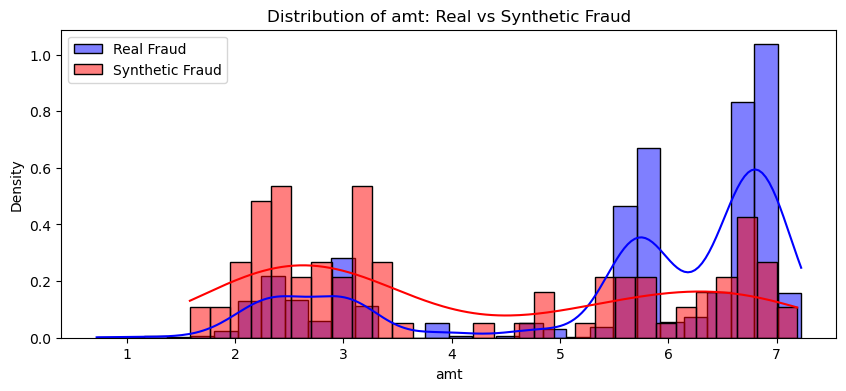

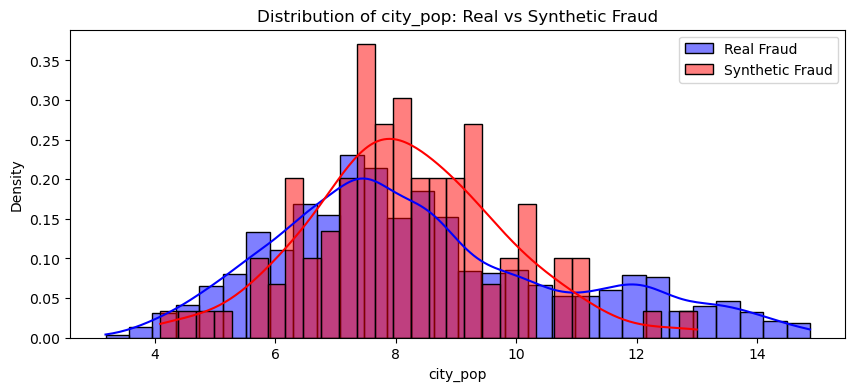

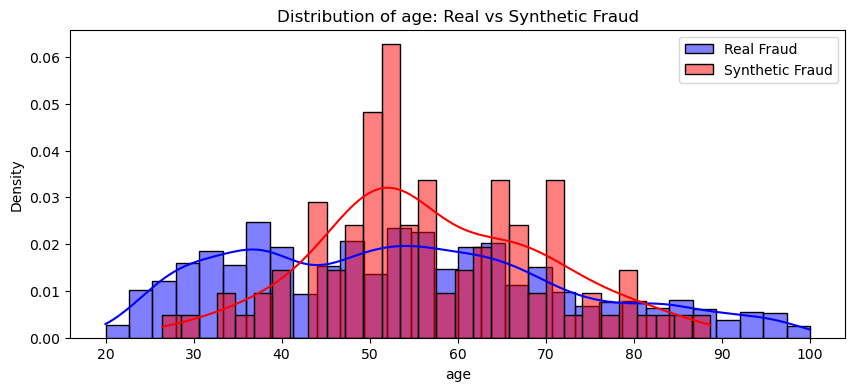

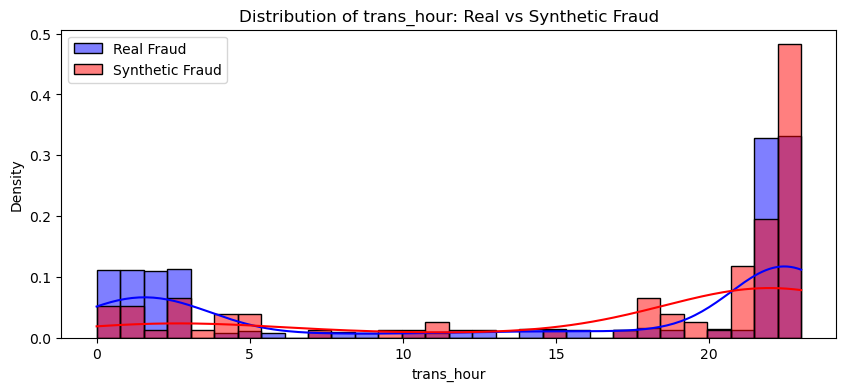

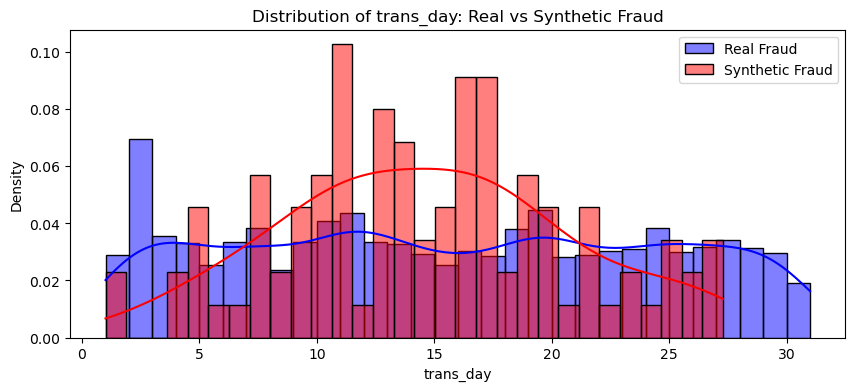

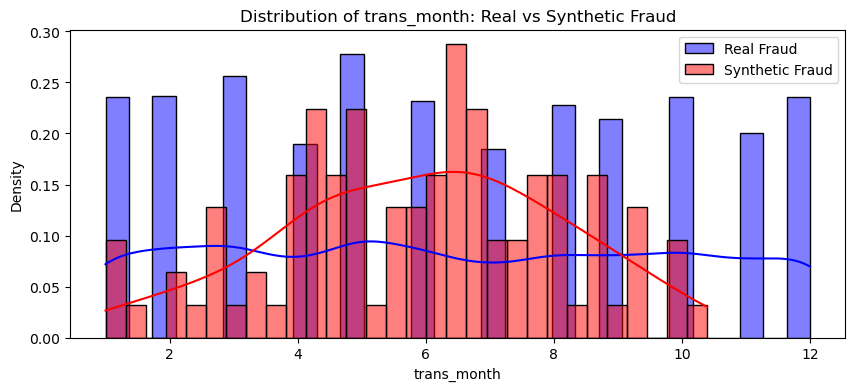

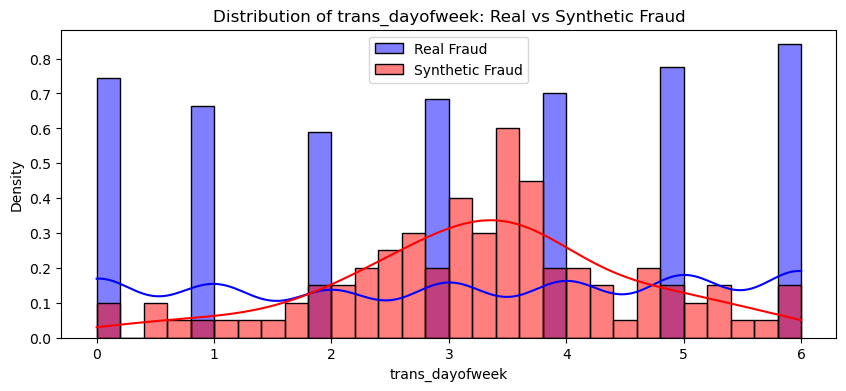

In [20]:
for col in ['amt', 'city_pop', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']:
    plt.figure(figsize=(10,4))
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Distribution of {col}: Real vs Synthetic Fraud")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

Synthetic numeric samples shape (normalized): torch.Size([1000, 11])
Synthetic categorical samples shape: torch.Size([1000, 8])
Real Fraud Numeric Statistics (Original Scale):
               amt          lat         long     city_pop    merch_lat  \
count  6273.000000  6273.000000  6273.000000  6273.000000  6273.000000   
mean      5.553833    38.720264   -90.184822     8.427249    38.711246   
std       1.627878     5.105657    14.214255     2.443052     5.140968   
min       0.722706    20.027100  -165.672302     3.178054    19.161783   
25%       5.479722    34.990601   -96.790901     6.679599    35.018204   
50%       5.958528    39.455799   -87.366699     7.940228    39.451233   
75%       6.802939    42.176701   -80.057297     9.893640    42.062038   
max       7.227692    66.693298   -67.950302    14.882529    67.188110   

        merch_long          age    trans_hour    trans_day  trans_month  \
count  6273.000000  6273.000000  6.273000e+03  6273.000000  6273.000000   
mean   

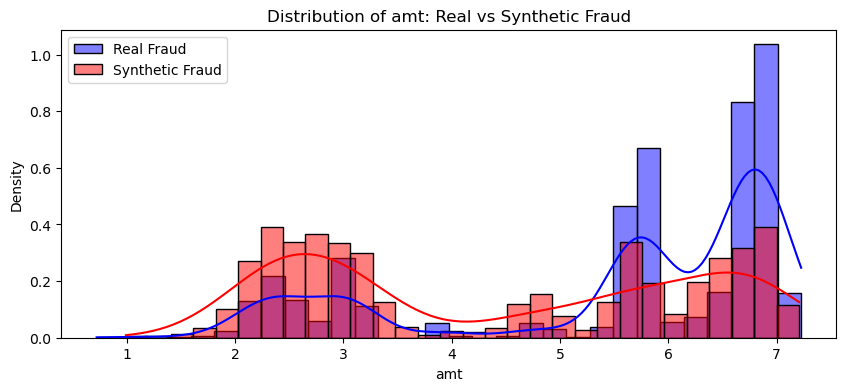

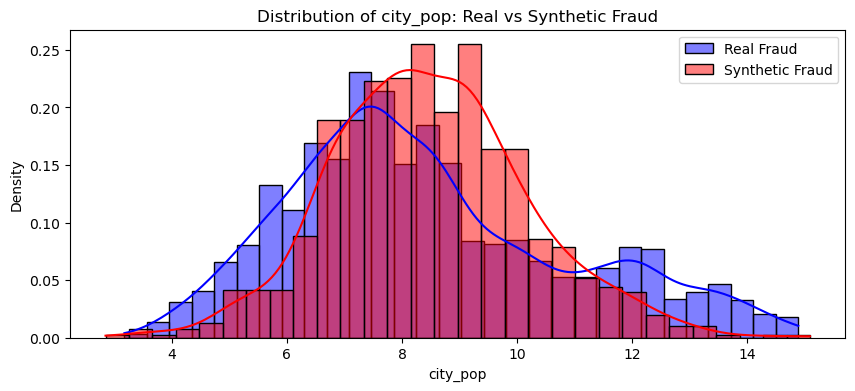

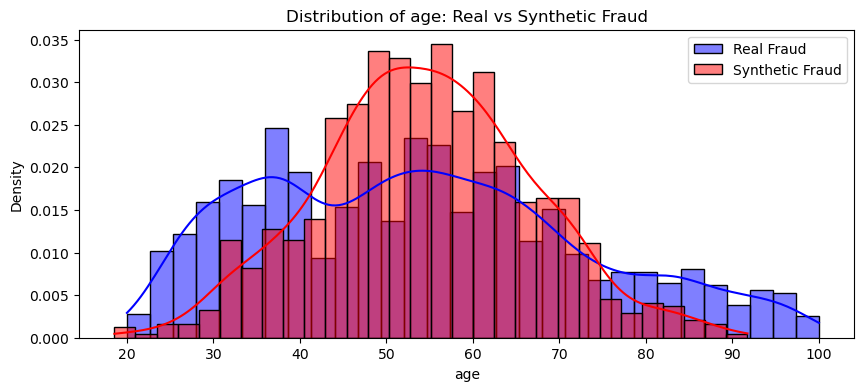

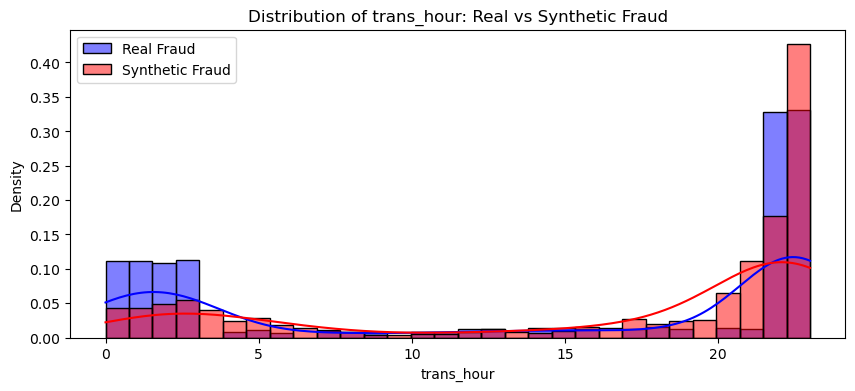

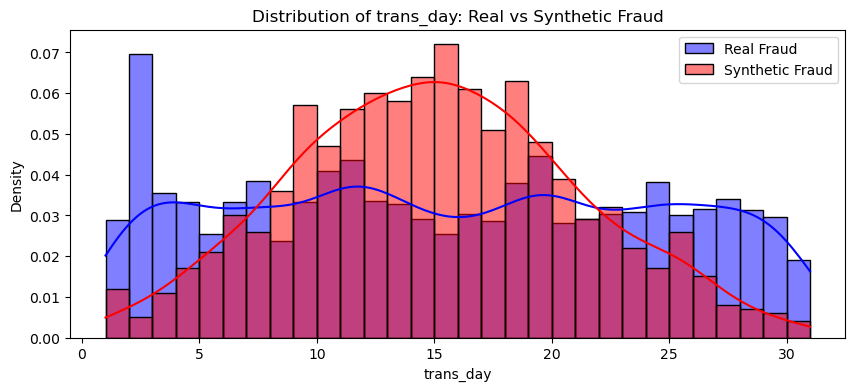

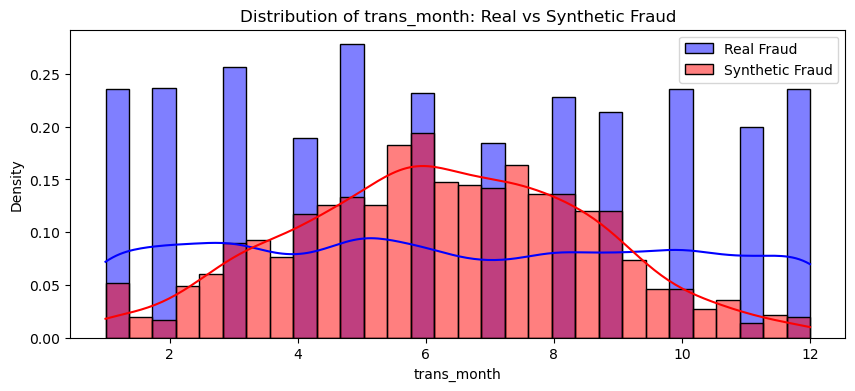

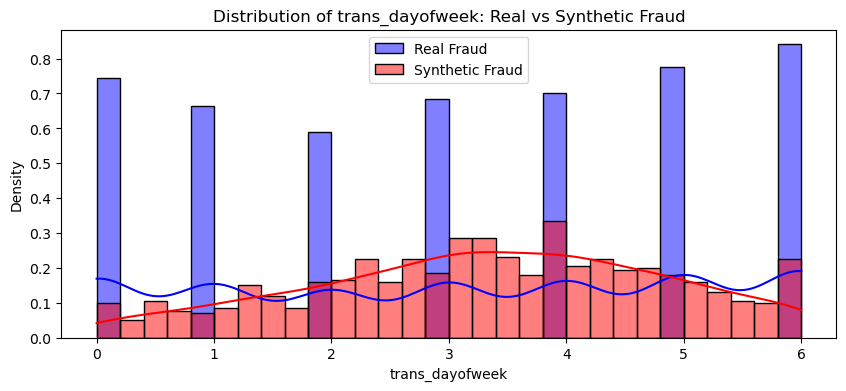

In [21]:
num_synthetic = 1000
synthetic_num_norm, synthetic_cat = generate_synthetic_fraud(model, num_synthetic)
print("Synthetic numeric samples shape (normalized):", synthetic_num_norm.shape)
print("Synthetic categorical samples shape:", synthetic_cat.shape)

#############################################
# Step 8: Inverse Transform Numeric Features to Original Scale
#############################################
synthetic_num_norm_np = synthetic_num_norm.cpu().numpy()
synthetic_num_original = scaler.inverse_transform(synthetic_num_norm_np)

numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']

#############################################
# Step 9: Combine Numeric and Categorical Parts and Evaluate
#############################################
synthetic_numeric_df = pd.DataFrame(synthetic_num_original, columns=numeric_features)
synthetic_cat_df = pd.DataFrame(synthetic_cat.cpu().numpy(), columns=cat_features)
synthetic_full_df = pd.concat([synthetic_numeric_df, synthetic_cat_df], axis=1)

X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32)
real_numeric = scaler.inverse_transform(X_fraud_tensor.cpu().numpy())
real_numeric_df = pd.DataFrame(real_numeric, columns=numeric_features)

print("Real Fraud Numeric Statistics (Original Scale):")
print(real_numeric_df.describe())
print("\nSynthetic Fraud Numeric Statistics (After Inverse Transform):")
print(synthetic_numeric_df.describe())

for col in ['amt', 'city_pop', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']:
    plt.figure(figsize=(10,4))
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Distribution of {col}: Real vs Synthetic Fraud")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import wasserstein_distance, ks_2samp
from scipy.spatial.distance import jensenshannon

In [23]:
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']


Feature: amt
  KS Statistic: 0.3524, p-value: 0.0000
  Wasserstein Distance: 1.1478
  Jensen-Shannon Divergence: 0.3334


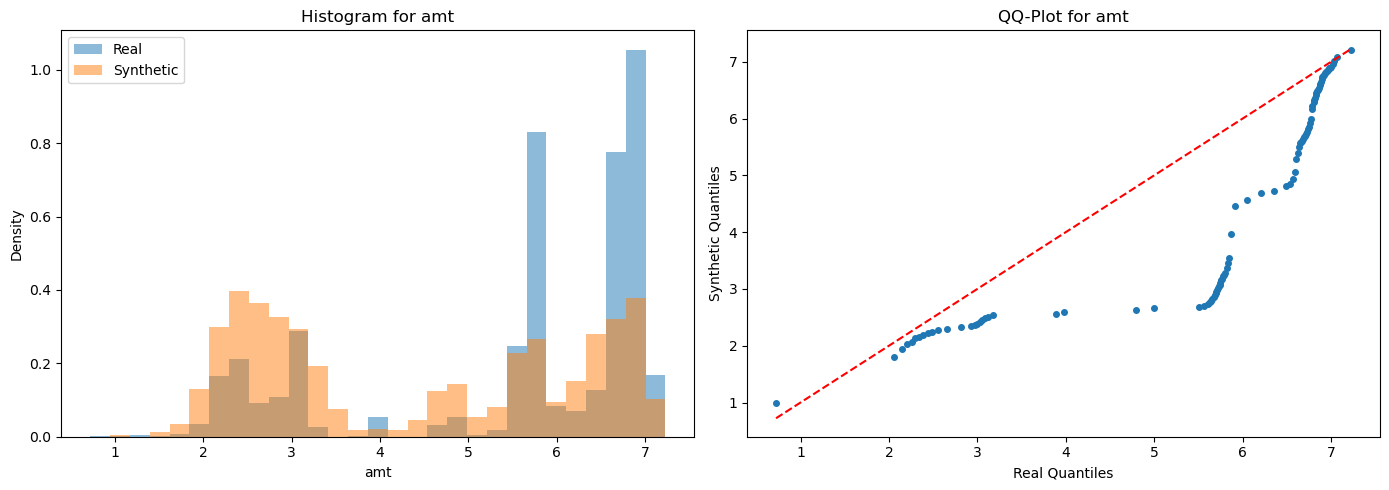


Feature: lat
  KS Statistic: 0.0528, p-value: 0.0156
  Wasserstein Distance: 0.5745
  Jensen-Shannon Divergence: 0.1214


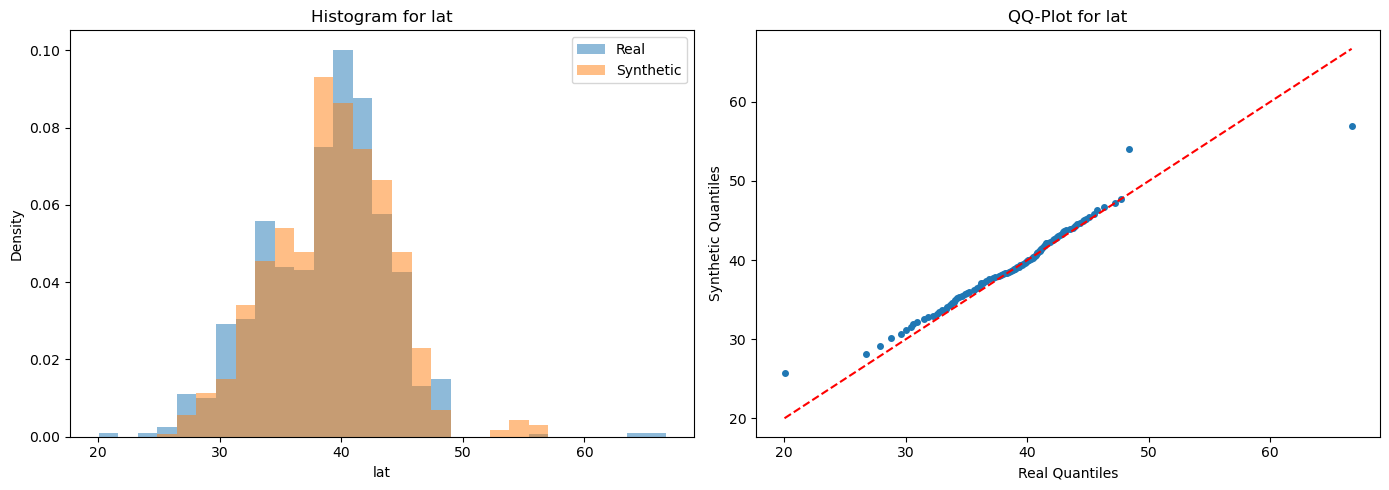


Feature: long
  KS Statistic: 0.0942, p-value: 0.0000
  Wasserstein Distance: 2.2672
  Jensen-Shannon Divergence: 0.1660


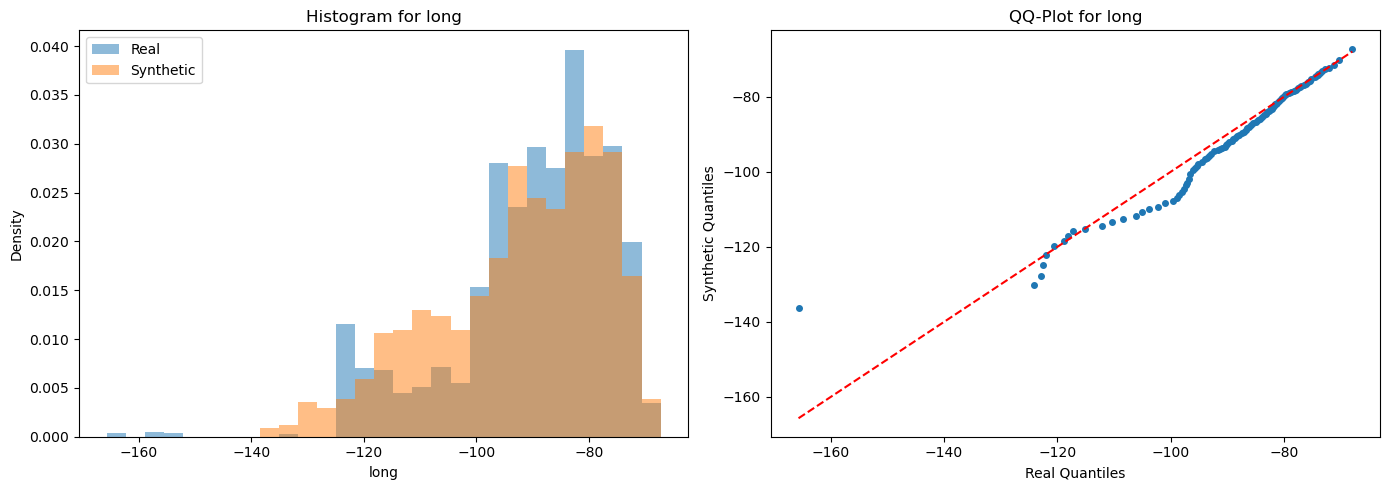


Feature: city_pop
  KS Statistic: 0.1338, p-value: 0.0000
  Wasserstein Distance: 0.7036
  Jensen-Shannon Divergence: 0.2275


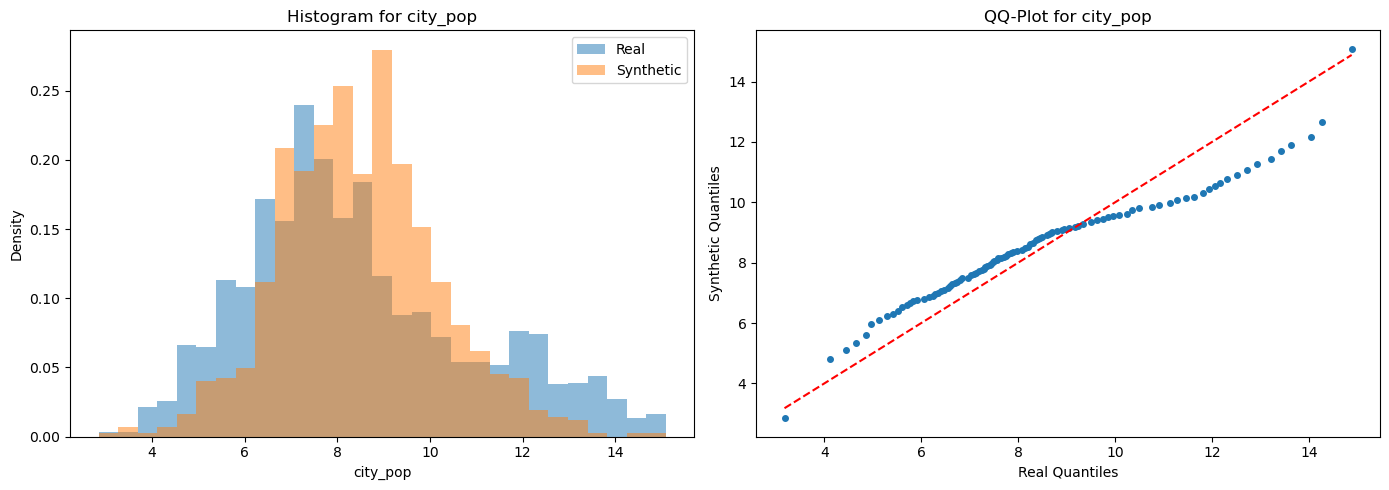


Feature: merch_lat
  KS Statistic: 0.0675, p-value: 0.0007
  Wasserstein Distance: 0.7768
  Jensen-Shannon Divergence: 0.1166


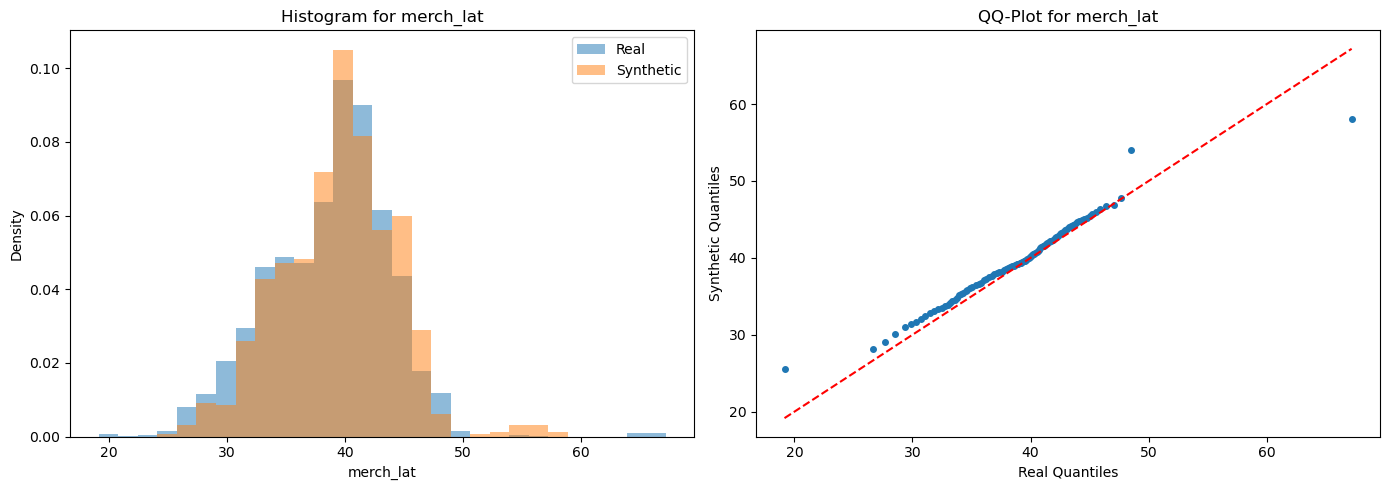


Feature: merch_long
  KS Statistic: 0.1021, p-value: 0.0000
  Wasserstein Distance: 2.6859
  Jensen-Shannon Divergence: 0.1592


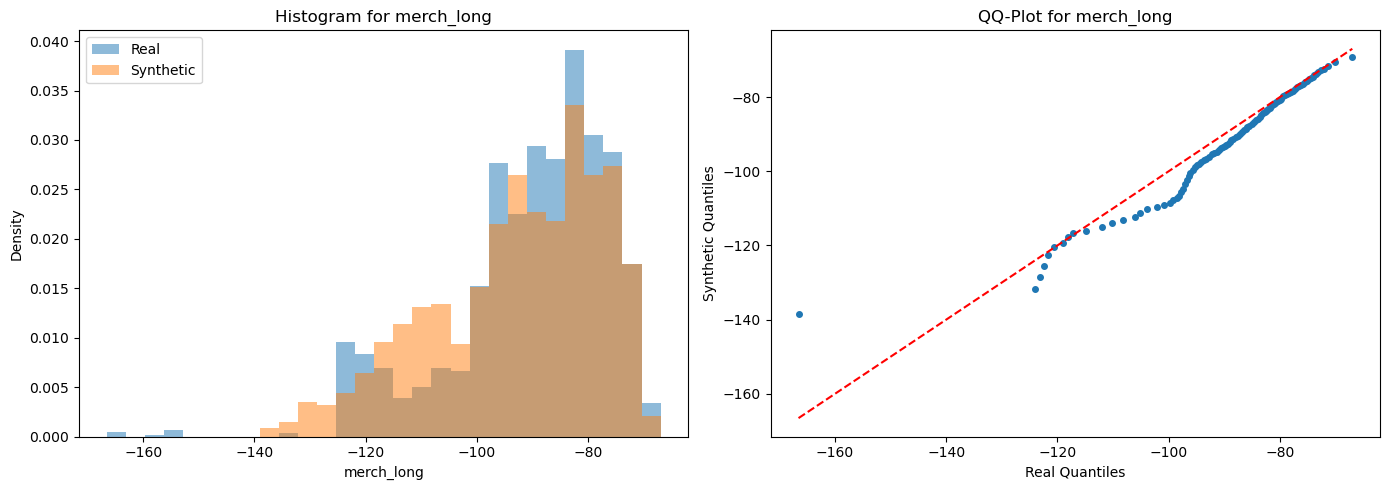


Feature: age
  KS Statistic: 0.1839, p-value: 0.0000
  Wasserstein Distance: 5.8231
  Jensen-Shannon Divergence: 0.2552


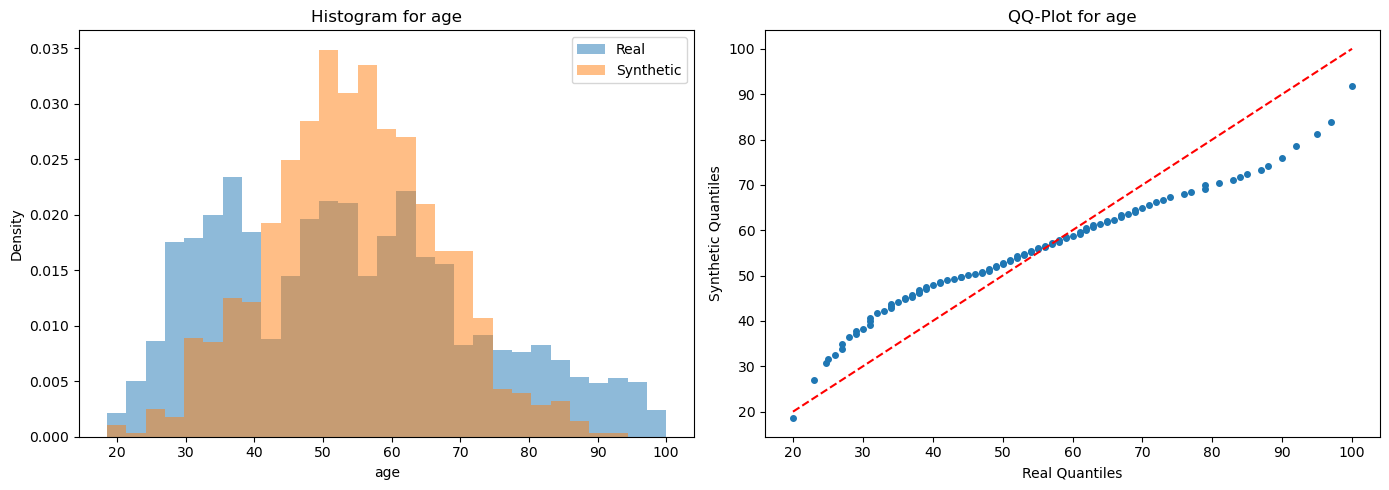


Feature: trans_hour
  KS Statistic: 0.1985, p-value: 0.0000
  Wasserstein Distance: 2.5467
  Jensen-Shannon Divergence: 0.2968


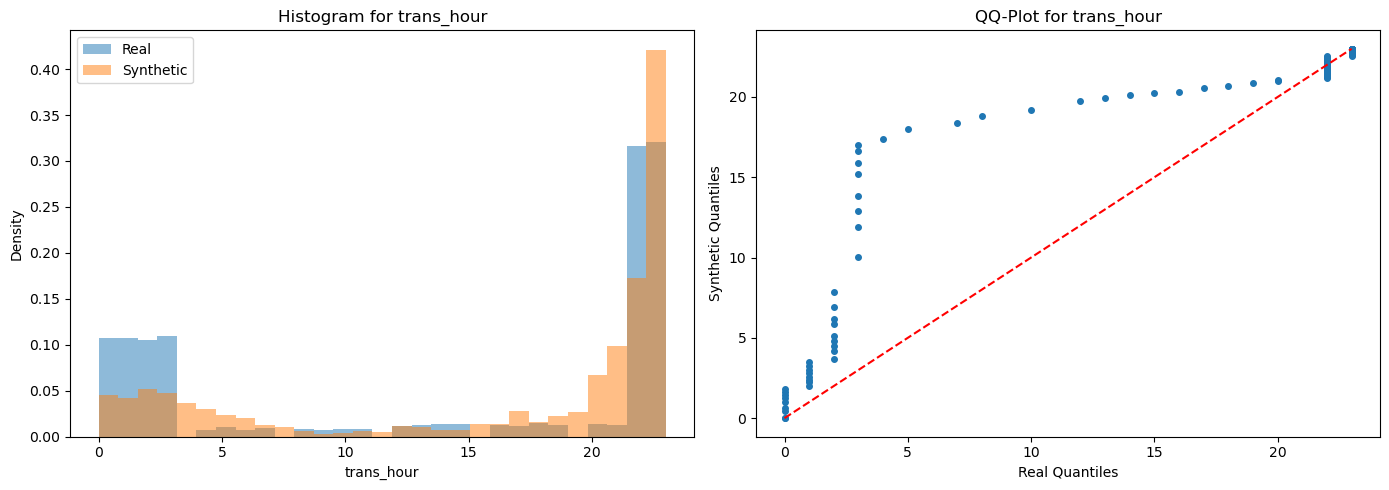


Feature: trans_day
  KS Statistic: 0.1719, p-value: 0.0000
  Wasserstein Distance: 2.7605
  Jensen-Shannon Divergence: 0.2659


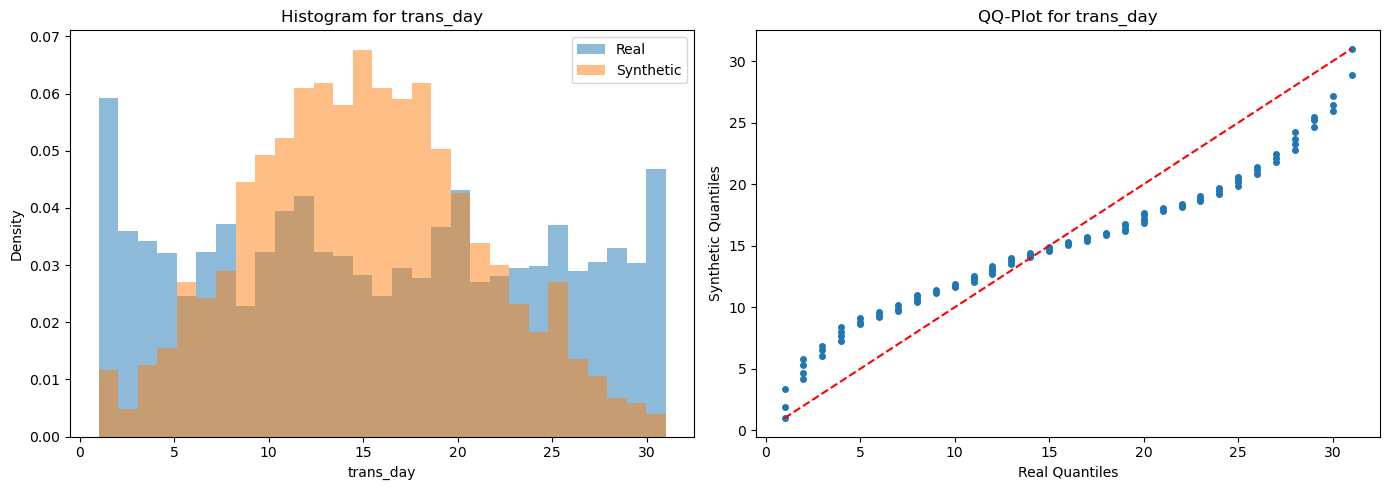


Feature: trans_month
  KS Statistic: 0.2127, p-value: 0.0000
  Wasserstein Distance: 1.1532
  Jensen-Shannon Divergence: 0.5584


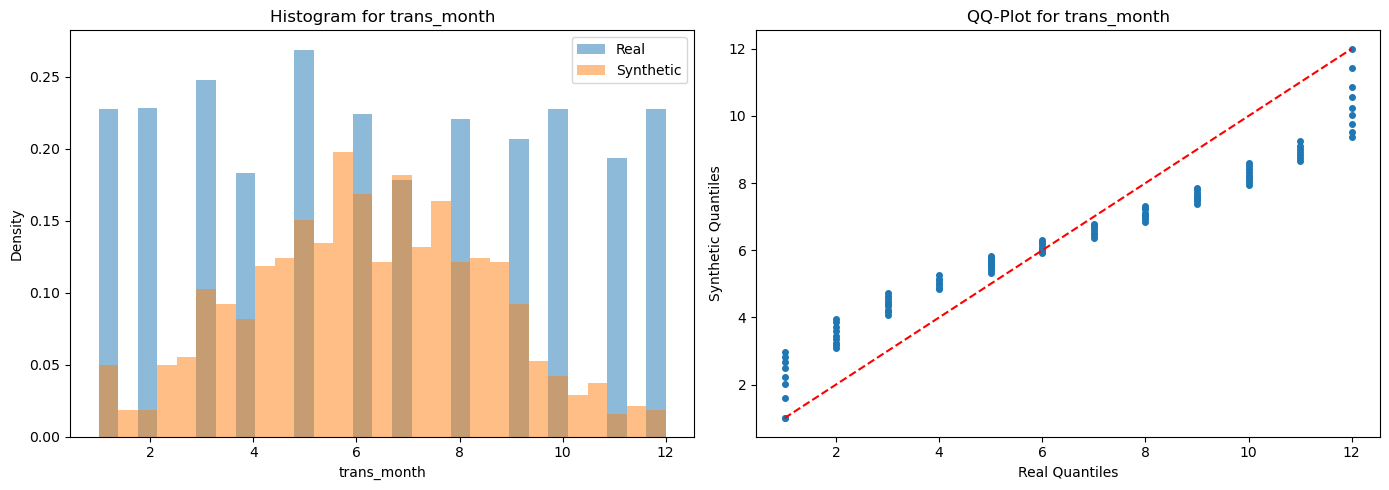


Feature: trans_dayofweek
  KS Statistic: 0.2020, p-value: 0.0000
  Wasserstein Distance: 0.5921
  Jensen-Shannon Divergence: 0.6203


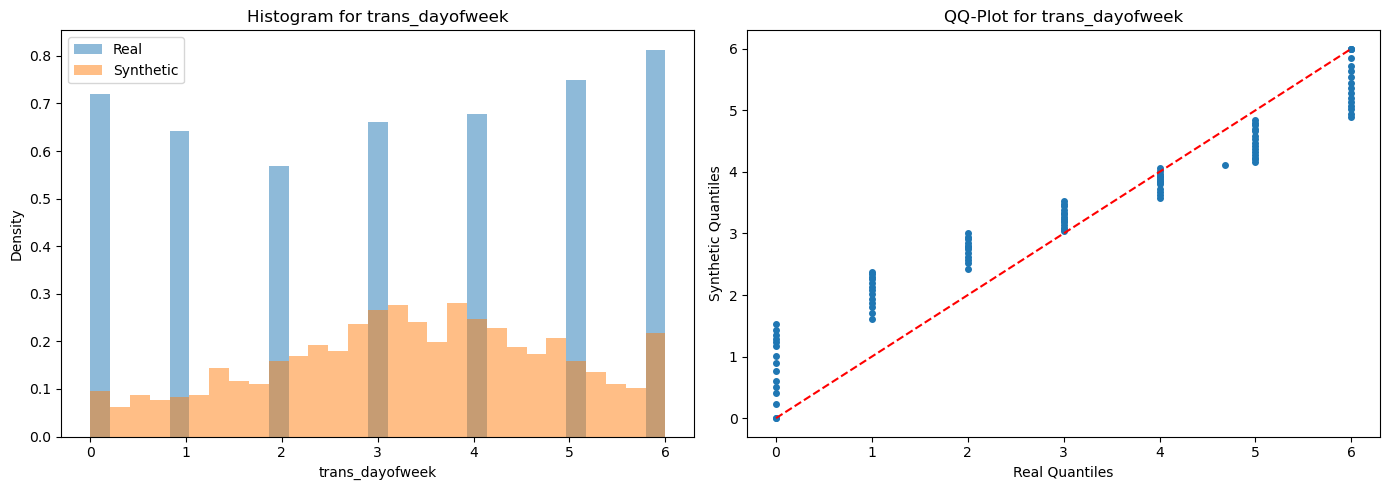

In [24]:
def compare_distributions(real_numeric_df, synthetic_numeric_df):
    # Loop through each feature to compute statistics and plot comparisons
    for col in numeric_features:
        # Extract data for this feature from both real and synthetic datasets
        real_data = real_numeric_df[col].values
        syn_data = synthetic_numeric_df[col].values
        
        # 1. Kolmogorov–Smirnov test:
        ks_stat, ks_p = ks_2samp(real_data, syn_data)
        
        # 2. Wasserstein distance:
        wass_distance = wasserstein_distance(real_data, syn_data)
        
        # 3. Jensen–Shannon divergence:
        # Define common bins using the min and max of both distributions
        min_val = min(real_data.min(), syn_data.min())
        max_val = max(real_data.max(), syn_data.max())
        bins = np.linspace(min_val, max_val, 30)
        
        # Estimate PDFs (using normalized histograms)
        real_hist, _ = np.histogram(real_data, bins=bins, density=True)
        syn_hist, _ = np.histogram(syn_data, bins=bins, density=True)
        
        # Normalize to form proper probability distributions
        real_pdf = real_hist / real_hist.sum()
        syn_pdf = syn_hist / syn_hist.sum()
        
        jsd = jensenshannon(real_pdf, syn_pdf)

        # Print out the computed metrics for each feature
        print(f"\nFeature: {col}")
        print(f"  KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
        print(f"  Wasserstein Distance: {wass_distance:.4f}")
        print(f"  Jensen-Shannon Divergence: {jsd:.4f}")

        # Create a figure with two subplots: Histogram and QQ plot
        plt.figure(figsize=(14, 5))

        # Subplot 1: Histogram with density overlay
        plt.subplot(1, 2, 1)
        plt.hist(real_data, bins=bins, alpha=0.5, density=True, label='Real')
        plt.hist(syn_data, bins=bins, alpha=0.5, density=True, label='Synthetic')
        plt.title(f"Histogram for {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()

        # Subplot 2: QQ-Plot comparing quantiles
        plt.subplot(1, 2, 2)
        quantiles = np.linspace(0, 100, 100)
        real_quantiles = np.percentile(real_data, quantiles)
        syn_quantiles = np.percentile(syn_data, quantiles)
        plt.plot(real_quantiles, syn_quantiles, 'o', markersize=4)
        plt.plot([real_quantiles.min(), real_quantiles.max()],
                 [real_quantiles.min(), real_quantiles.max()], 'r--')
        plt.title(f"QQ-Plot for {col}")
        plt.xlabel("Real Quantiles")
        plt.ylabel("Synthetic Quantiles")
        
        plt.tight_layout()
        plt.show()

compare_distributions(real_numeric_df, synthetic_numeric_df)

In [25]:
import numpy as np
import pandas as pd
from scipy import stats

def enhanced_statistical_comparison(real_numeric_df, synthetic_numeric_df, numeric_features):
    """
    For each numeric feature, this function computes:
      - Kolmogorov–Smirnov (KS) test statistic and p-value.
      - Anderson–Darling (AD) test statistic and significance level.
      - Skewness and kurtosis for both real and synthetic data.
      
    Parameters:
      real_numeric_df (pd.DataFrame): DataFrame containing real numeric data.
      synthetic_numeric_df (pd.DataFrame): DataFrame containing synthetic numeric data.
      numeric_features (list): List of feature names to compare.
      
    The function prints the statistics for each feature.
    """
    print("Enhanced Statistical Comparison")
    print("=" * 60)
    
    for col in numeric_features:
        # Extract data and remove missing values
        real_data = real_numeric_df[col].dropna().values
        syn_data = synthetic_numeric_df[col].dropna().values
        
        # Kolmogorov–Smirnov test
        ks_stat, ks_p = stats.ks_2samp(real_data, syn_data)
        
        # Anderson–Darling Test (two-sample)
        # anderson_ksamp may throw an exception if both distributions are identical,
        # so we safely wrap it in a try/except block.
        try:
            ad_result = stats.anderson_ksamp([real_data, syn_data])
            ad_stat = ad_result.statistic
            ad_sig = ad_result.significance_level
        except Exception as e:
            ad_stat = np.nan
            ad_sig = np.nan
            print(f"Error in Anderson–Darling test for {col}: {e}")

        # Compute skewness and kurtosis (Fisher's definition, normal distribution => 0 kurtosis)
        real_skew = stats.skew(real_data)
        syn_skew = stats.skew(syn_data)
        real_kurt = stats.kurtosis(real_data)
        syn_kurt = stats.kurtosis(syn_data)
        
        # Display the results
        print(f"\nFeature: {col}")
        print("-" * 60)
        print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
        print(f"Anderson–Darling Statistic: {ad_stat:.4f}, significance level: {ad_sig:.4f}")
        print(f"Real Skewness: {real_skew:.4f}, Synthetic Skewness: {syn_skew:.4f}")
        print(f"Real Kurtosis: {real_kurt:.4f}, Synthetic Kurtosis: {syn_kurt:.4f}")
        print("-" * 60)

# Define your list of numeric feature names.
numeric_features = ['amt', 'city_pop', 'merch_lat', 'merch_long', 
                    'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']


if __name__ == "__main__":

    enhanced_statistical_comparison(real_numeric_df, synthetic_numeric_df, numeric_features)

Enhanced Statistical Comparison

Feature: amt
------------------------------------------------------------
KS Statistic: 0.3524, p-value: 0.0000
Anderson–Darling Statistic: 242.4867, significance level: 0.0010
Real Skewness: -1.0827, Synthetic Skewness: 0.0937
Real Kurtosis: -0.3416, Synthetic Kurtosis: -1.6367
------------------------------------------------------------

Feature: city_pop
------------------------------------------------------------
KS Statistic: 0.1338, p-value: 0.0000
Anderson–Darling Statistic: 51.4074, significance level: 0.0010
Real Skewness: 0.5893, Synthetic Skewness: 0.2242
Real Kurtosis: -0.2915, Synthetic Kurtosis: 0.3606
------------------------------------------------------------

Feature: merch_lat
------------------------------------------------------------
KS Statistic: 0.0675, p-value: 0.0007
Anderson–Darling Statistic: 9.0413, significance level: 0.0010
Real Skewness: 0.0380, Synthetic Skewness: 0.0898
Real Kurtosis: 1.7684, Synthetic Kurtosis: 0.7068


C:\Users\Owner\AppData\Local\Temp\ipykernel_22040\835363777.py:34: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([real_data, syn_data])
